In [128]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from torch.utils.data import WeightedRandomSampler
import random
from sklearn.preprocessing import normalize

In [129]:
nf = 1470

lr = 5e-6

epochs = 100

batch_size = 1

In [137]:
class Features(Dataset):
    def __init__(self, x, y):
        mean = np.mean(x, axis=1).reshape(-1, 1)
        std = np.std(x, axis=1).reshape(-1, 1)
        x = (x-mean)/std
        self.x = torch.as_tensor(x)

        self.y = torch.as_tensor(y)

    def __getitem__(self, index):
        feature = self.x[index]
        label = self.y[index]
        sample = {'feature': feature, 'label': label}

        return sample

    def __len__(self):
        return len(self.x)

In [138]:
def create_train_and_test_set_balanced(X, y, train_ratio=0.75):
    # TODO
    # process the list of (x,y) pairs and split them 80-20 into train and test set
    # train_x is a list of name embeddings each of size (num_characters_in_name, 1, n_letters), train_y is the corresponding list of language category index. Same for test_x and test_y

    X, X_rem, y, y_rem = X[0:int(train_ratio * len(X))], X[int(train_ratio * len(X)) + 1:-1], y[0:int(train_ratio * len(y))], y[int(train_ratio * len(y)) + 1:-1]
    counts = np.bincount(y)
    label_weights = 1.0 / counts
    weights = label_weights[y]
    index = list(WeightedRandomSampler(weights, len(weights)))
    X_train, y_train = [X[i] for i in index], [y[i] for i in index]

    return X_train, X_rem, y_train, y_rem

In [139]:
HGG_dataset = np.load('HGG_Flair_dataset.npy', allow_pickle=True)
LGG_dataset = np.load('LGG_Flair_dataset.npy', allow_pickle=True)
labels = np.hstack((np.zeros(len(HGG_dataset)), np.ones(len(LGG_dataset)))).astype(int)
dataset = np.vstack((HGG_dataset, LGG_dataset))

c = list(zip(dataset, labels))
random.shuffle(c)
dataset, labels = zip(*c)
dataset = list(dataset)
labels = list(labels)

X_train, X_test, y_train, y_test = create_train_and_test_set_balanced(dataset, labels, 0.4)
# X_train = normalize(X_train, axis=1)
# X_test = normalize(X_test, axis=1)

# X_train, X_test, y_train, y_test = train_test_split(dataset,labels,train_size=0.7, shuffle=True)

train_data = Features(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = Features(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [140]:
class Encoder(torch.nn.Module):
    def __init__(self, nf):
        super(Encoder, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(nf, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 4),
        )
    
    def forward(self, inputs):
        encoded = self.encoder(inputs)

        return encoded.view(-1, 4)

In [158]:
class Decoder(torch.nn.Module):
    def __init__(self, nf):
        super(Decoder, self).__init__()

        self.decoder = torch.nn.Sequential(
              torch.nn.Linear(4, 8),
              torch.nn.ReLU(),
              torch.nn.Linear(8, 16),
              torch.nn.ReLU(),
              torch.nn.Linear(16, 32),
              torch.nn.ReLU(),
              torch.nn.Linear(32, 64),
              torch.nn.ReLU(),
              torch.nn.Linear(64, 128),
              torch.nn.ReLU(),
              torch.nn.Linear(128, nf),
              torch.nn.Sigmoid(),
        )

    def forward(self, encoded):
        decoded = self.decoder(encoded)

        return decoded.view(-1, nf)

In [142]:
encoder = Encoder(nf)
decoder = Decoder(nf)

parameters = list(encoder.parameters())+ list(decoder.parameters())
optimizer = torch.optim.Adam(parameters, lr=lr, weight_decay=1e-8)
loss_function = torch.nn.MSELoss()

In [143]:
losses = []
for epoch in range(epochs):
    for i_batch, data in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = data['feature'].view(-1, nf).to(torch.float32)

        encoded = encoder(inputs)
        decoded = decoder(encoded)

        loss = loss_function(decoded, inputs)
        loss.backward()
        optimizer.step()

    losses.append(loss)
    print('[{}/{}] Loss:'.format(epoch+1, epochs), loss.item())

torch.save(encoder, 'encoder.pth')

[1/100] Loss: 1.2489643096923828
[2/100] Loss: 1.2478928565979004
[3/100] Loss: 1.2467221021652222
[4/100] Loss: 1.245487928390503
[5/100] Loss: 1.2443082332611084
[6/100] Loss: 1.2429351806640625
[7/100] Loss: 1.2414884567260742
[8/100] Loss: 1.2398581504821777
[9/100] Loss: 1.2381385564804077
[10/100] Loss: 1.2363709211349487
[11/100] Loss: 1.2343988418579102
[12/100] Loss: 1.2329074144363403
[13/100] Loss: 1.2300827503204346
[14/100] Loss: 1.2283765077590942
[15/100] Loss: 1.2257040739059448
[16/100] Loss: 1.2223460674285889
[17/100] Loss: 1.2202075719833374
[18/100] Loss: 1.217688798904419
[19/100] Loss: 1.2148813009262085
[20/100] Loss: 1.2102371454238892
[21/100] Loss: 1.206694483757019
[22/100] Loss: 1.204814076423645
[23/100] Loss: 1.1986258029937744
[24/100] Loss: 1.1943981647491455
[25/100] Loss: 1.1940875053405762
[26/100] Loss: 1.1871336698532104
[27/100] Loss: 1.1802088022232056
[28/100] Loss: 1.1786543130874634
[29/100] Loss: 1.175611138343811
[30/100] Loss: 1.17022442817

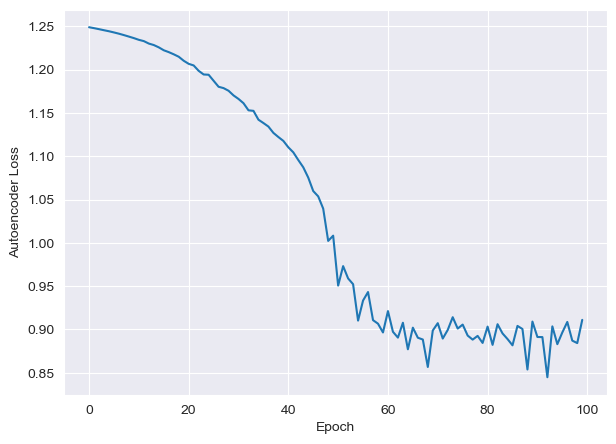

In [144]:
fig = plt.figure(figsize=(7, 5))
losses = [loss.detach() for loss in losses]
plt.xlabel('Epoch')
plt.ylabel('Autoencoder Loss')
plt.plot(range(100), losses)
plt.savefig('loss.pdf')

In [145]:
encoder = torch.load('encoder.pth')
train_features_processed = [encoder(data['feature'].to(torch.float32)) for data in train_data]
train_features_processed = [data.detach().numpy().squeeze(0) for data in train_features_processed]

In [146]:
test_features_processed = [encoder(data['feature'].to(torch.float32)) for data in test_data]
test_features_processed = [data.detach().numpy().squeeze(0) for data in test_features_processed]

0.7361963190184049


/Users/nicklu/opt/anaconda3/envs/cv2022/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<AxesSubplot:>

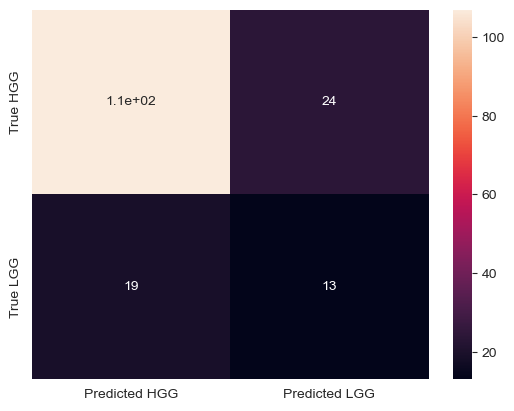

In [166]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
pred = clf.predict(X_test)

cm = pd.DataFrame(confusion_matrix(y_test,pred),index=["True HGG","True LGG"],columns=["Predicted HGG","Predicted LGG"])
sn.heatmap(data=cm,annot=True,xticklabels=True,yticklabels=True)

0.7423312883435583


<AxesSubplot:>

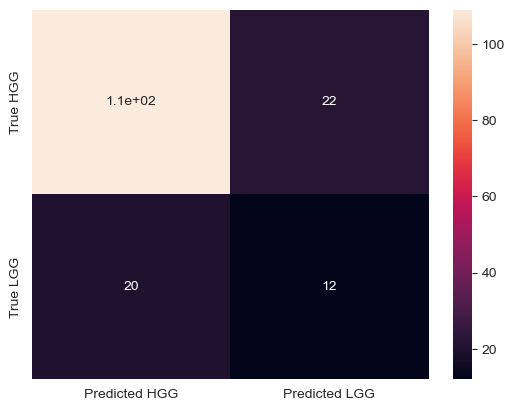

In [165]:
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=5)
clf_rf.fit(X_train, y_train)
print(clf_rf.score(X_test, y_test))

pred = clf_rf.predict(X_test)

cm = pd.DataFrame(confusion_matrix(y_test,pred),index=["True HGG","True LGG"],columns=["Predicted HGG","Predicted LGG"])
sn.heatmap(data=cm,annot=True,xticklabels=True,yticklabels=True)

[1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1]
0.6687116564417178


<AxesSubplot:>

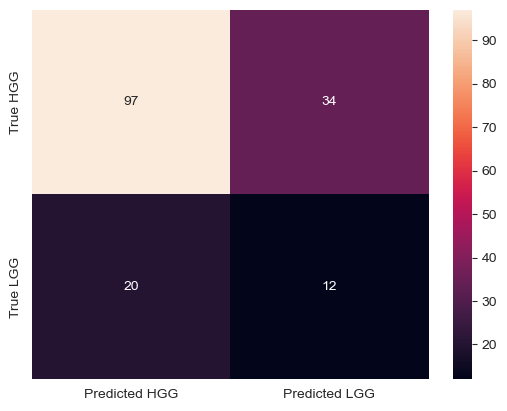

In [157]:
clf_svc = SVC(kernel='rbf', gamma=1e-5)
clf_svc.fit(X_train, y_train)
print(y_train)
print(clf_svc.score(X_test, y_test))

pred = clf_svc.predict(X_test)

cm = pd.DataFrame(confusion_matrix(y_test,pred),index=["True HGG","True LGG"],columns=["Predicted HGG","Predicted LGG"])
sn.heatmap(data=cm,annot=True,xticklabels=True,yticklabels=True)

0.6196319018404908


<AxesSubplot:>

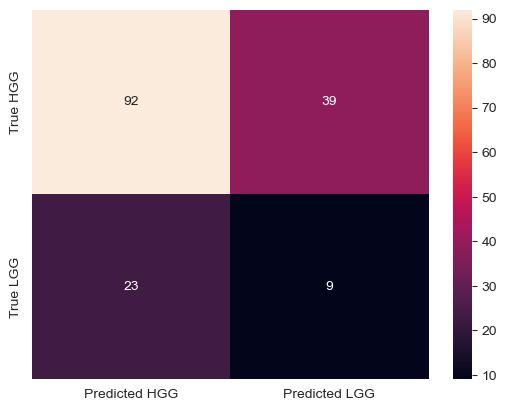

In [174]:
clf_svc = SVC(kernel='rbf', gamma=1e1)
clf_svc.fit(train_features_processed, y_train)
print(clf_svc.score(test_features_processed, y_test))

pred = clf_svc.predict(test_features_processed)

cm = pd.DataFrame(confusion_matrix(y_test,pred),index=["True HGG","True LGG"],columns=["Predicted HGG","Predicted LGG"])
sn.heatmap(data=cm,annot=True,xticklabels=True,yticklabels=True)